<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-Objective" data-toc-modified-id="Project-Objective-1">Project Objective</a></span></li><li><span><a href="#Project-setup" data-toc-modified-id="Project-setup-2">Project setup</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#python-pickle" data-toc-modified-id="python-pickle-2.0.1">python pickle</a></span></li><li><span><a href="#Number-of-articles-in-each-category" data-toc-modified-id="Number-of-articles-in-each-category-2.0.2">Number of articles in each category</a></span></li><li><span><a href="#News-length-by-category" data-toc-modified-id="News-length-by-category-2.0.3">News length by category</a></span></li></ul></li></ul></li><li><span><a href="#Pre-processing-&amp;-Feature-Engineering" data-toc-modified-id="Pre-processing-&amp;-Feature-Engineering-3">Pre-processing &amp; Feature Engineering</a></span><ul class="toc-item"><li><span><a href="#Coding-the-labels" data-toc-modified-id="Coding-the-labels-3.1">Coding the labels</a></span></li><li><span><a href="#Create-the-train-and-test-sets" data-toc-modified-id="Create-the-train-and-test-sets-3.2">Create the train and test sets</a></span></li><li><span><a href="#Create-features-using-TF-IDF" data-toc-modified-id="Create-features-using-TF-IDF-3.3">Create features using TF-IDF</a></span></li><li><span><a href="#Creating-the-features" data-toc-modified-id="Creating-the-features-3.4">Creating the features</a></span></li><li><span><a href="#Looking-at-the-result" data-toc-modified-id="Looking-at-the-result-3.5">Looking at the result</a></span></li></ul></li><li><span><a href="#Save-the-data-&amp;-features" data-toc-modified-id="Save-the-data-&amp;-features-4">Save the data &amp; features</a></span></li></ul></div>

https://towardsdatascience.com/text-classification-in-python-dd95d264c802

# Project Objective

Classify (catagorize) news articles based on their content.  There are five categories - business, entertainment, politics, sport and technology.

- A labeled dataset has been provided. Approximately 2200 articles from the BBC.
    - Each individual article was provided in its own file.
    - The data has already been processed into one large file - News_dataset.csv
    - Every article became a row in the corpus.
- This is a supervised learning problem

# Project setup

- Connect to Google Drive
- Inside of your NLP_data folder, create a new folder named Pickles
- News_dataset.csv will be read from github.  Output files will be placed in the the Pickles folder.

### python pickle

Pickle in Python is primarily used in serializing and deserializing a Python object structure. In other words, it's the process of converting a Python object into a byte stream to store it in a file/database, maintain program state across sessions, or transport data over the network.

https://towardsdatascience.com/stop-using-csvs-for-storage-pickle-is-an-80-times-faster-alternative-832041bbc199

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
sns.set_style("whitegrid")
#import altair as alt
#alt.renderers.enable("notebook")

# Code for hiding seaborn warnings
import warnings
warnings.filterwarnings("ignore")


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2

from sklearn.ensemble import RandomForestClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import ShuffleSplit

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')


Loading the dataset:

In [ ]:
url = 'https://raw.githubusercontent.com/jimcody2014/nlp_cdc/main/data/News_dataset.csv'
df = pd.read_csv(url, sep=';',usecols = [1,2])

In [ ]:
df.head()

### Number of articles in each category

<AxesSubplot:xlabel='Category', ylabel='count'>

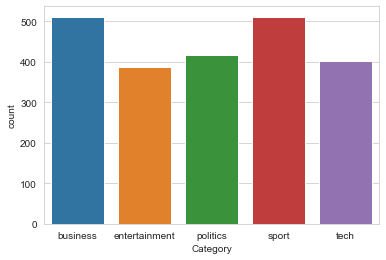

In [8]:
sns.countplot(x="Category", data=df)

### News length by category

Definition of news length field. Although there are special characters in the text (``\r, \n``), it will be useful as an approximation.

In [9]:
df['News_length'] = df['Content'].str.len()

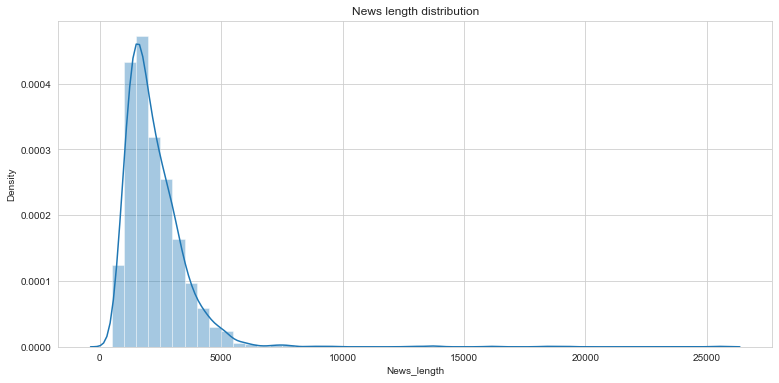

In [10]:
plt.figure(figsize=(12.8,6))
sns.distplot(df['News_length']).set_title('News length distribution');

In [11]:
df['News_length'].describe()

count     2225.000000
mean      2264.790562
std       1364.305951
min        502.000000
25%       1447.000000
50%       1966.000000
75%       2803.000000
max      25484.000000
Name: News_length, dtype: float64

Let's remove from the 95% percentile onwards to better appreciate the histogram:

In [12]:
quantile_95 = df['News_length'].quantile(0.95)
df_95 = df[df['News_length'] < quantile_95]

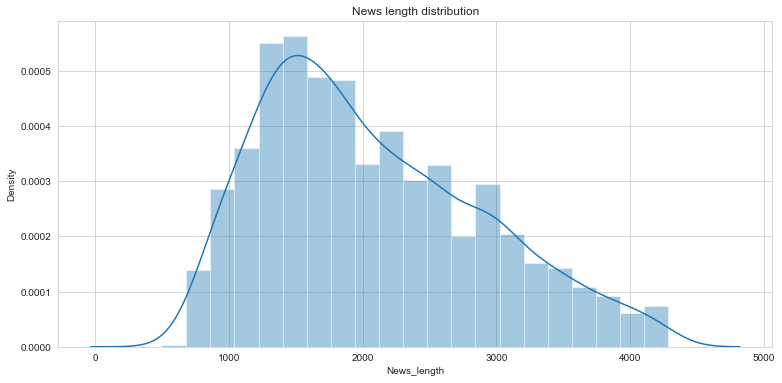

In [13]:
plt.figure(figsize=(12.8,6))
sns.distplot(df_95['News_length']).set_title('News length distribution');

We can get the number of news articles with more than 10,000 characters:

In [14]:
df_more10k = df[df['News_length'] > 10000]
len(df_more10k)

7

Let's see one:

In [ ]:
#df_more10k['Content'].iloc[0]

It's just a large news article.

Let's now plot a boxplot:

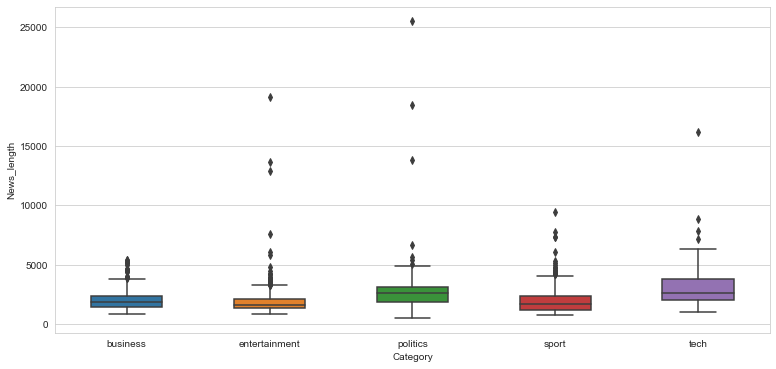

In [16]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df, x='Category', y='News_length', width=.5);

Now, let's remove the larger documents for better comprehension:

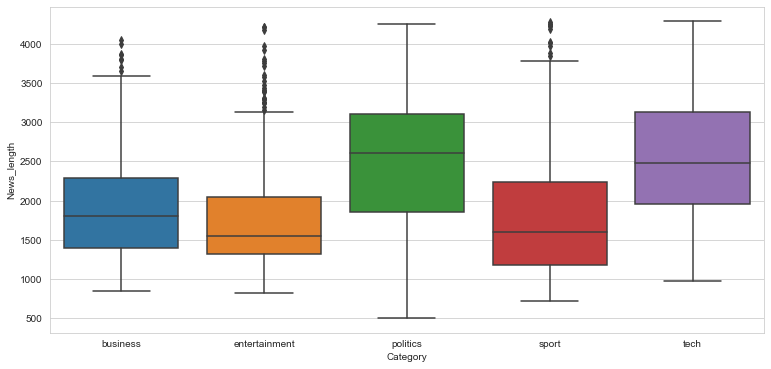

In [17]:
plt.figure(figsize=(12.8,6))
sns.boxplot(data=df_95, x='Category', y='News_length');

We can see that, although the length distribution is different for every category, the difference is not too big. If we had way too different lengths between categories we would have a problem since the feature creation process may take into account counts of words. However, when creating the features with TF-IDF scoring, we will normalize the features just to avoid this.

At this point, we cannot do further Exploratory Data Analysis. We'll turn onto the **Feature Engineering** section.

We'll save the dataset:

In [ ]:
#with open('News_dataset.pickle', 'wb') as output:
#   pickle.dump(df, output)

# Pre-processing & Feature Engineering

In [ ]:
#path_df = "/home/lnc/0. Latest News Classifier/02. Exploratory Data Analysis/News_dataset.pickle"

#path_df ='/Users/jimcody/Documents/2021Python/nlp/data/News_dataset.pickle'
#with open(path_df, 'rb') as data:
#    df = pickle.load(data)

In [18]:
df.head()

,Content,Category,News_length
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2559
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,2251
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,1551
3,High fuel prices hit BA's profits\n\nBritish A...,business,2411
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,1569


In [19]:
# \r and \n  \r - carraige return.  \n - new line
df['Content_Parsed_1'] = df['Content'].str.replace("\r", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("\n", " ")
df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace("    ", " ")

df['Content_Parsed_1'] = df['Content_Parsed_1'].str.replace('"', '')  # remove double-quote
df['Content_Parsed_2'] = df['Content_Parsed_1'].str.lower()           # make lowercase

punctuation_signs = list("?:!.,;")
df['Content_Parsed_3'] = df['Content_Parsed_2']                       # remove punctuation
for punct_sign in punctuation_signs:
    df['Content_Parsed_3'] = df['Content_Parsed_3'].str.replace(punct_sign, '')
    
df['Content_Parsed_4'] = df['Content_Parsed_3'].str.replace("'s", "") # # Possessive pronouns

In [20]:
# Lemmatize
wordnet_lemmatizer = WordNetLemmatizer()

# Iterate over every word in order to lemmatize
nrows = len(df)
lemmatized_text_list = []

for row in range(0, nrows):
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = df.loc[row]['Content_Parsed_4']
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
    
df['Content_Parsed_5'] = lemmatized_text_list

In [21]:
# Stop words
stop_words = list(stopwords.words('english'))

df['Content_Parsed_6'] = df['Content_Parsed_5']     # Put 5 into 6

for stop_word in stop_words:                        # Replace 6 with blank if it is a stopword

    regex_stopword = r"\b" + stop_word + r"\b"
    df['Content_Parsed_6'] = df['Content_Parsed_6'].str.replace(regex_stopword, '')

# This might result in some double and triple spacing between words.  
# That will be corrected when the content is tokenized.

stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [22]:
df.head(1)

,Content,Category,News_length,Content_Parsed_1,Content_Parsed_2,Content_Parsed_3,Content_Parsed_4,Content_Parsed_5,Content_Parsed_6
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,2559,Ad sales boost Time Warner profit Quarterly p...,ad sales boost time warner profit quarterly p...,ad sales boost time warner profit quarterly p...,ad sales boost time warner profit quarterly p...,ad sales boost time warner profit quarterly p...,ad sales boost time warner profit quarterly p...


In [27]:
list_columns = ['Category', 'Content', 'Content_Parsed_6']
df = df[list_columns]

df = df.rename(columns={'Content_Parsed_6': 'Content_Parsed'})

In [28]:
df.head()

,Category,Content,Content_Parsed
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly p...
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit h...
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owners emb...
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airways...
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk dr...


## Coding the labels

In [29]:
category_codes = {
    'business': 0,
    'entertainment': 1,
    'politics': 2,
    'sport': 3,
    'tech': 4
}

# Category mapping
df['Category_Code'] = df['Category']
df = df.replace({'Category_Code':category_codes})
df.head()

,Category,Content,Content_Parsed,Category_Code
0,business,Ad sales boost Time Warner profit\n\nQuarterly...,ad sales boost time warner profit quarterly p...,0
1,business,Dollar gains on Greenspan speech\n\nThe dollar...,dollar gain greenspan speech dollar hit h...,0
2,business,Yukos unit buyer faces loan claim\n\nThe owner...,yukos unit buyer face loan claim owners emb...,0
3,business,High fuel prices hit BA's profits\n\nBritish A...,high fuel price hit ba profit british airways...,0
4,business,Pernod takeover talk lifts Domecq\n\nShares in...,pernod takeover talk lift domecq share uk dr...,0


## Create the train and test sets

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['Content_Parsed'], 
                                                    df['Category_Code'], 
                                                    test_size=0.15, 
                                                    random_state=8)

## Create features using TF-IDF

We have various options:

* Count Vectors as features
* TF-IDF Vectors as features
* Word Embeddings as features
* Text / NLP based features
* Topic Models as features

*Count vectors and TF-IDF are considered 'bag of words' methods that do not take the order of words in a sentence into consideration.*

An almost understandable word embedding article - https://jalammar.github.io/illustrated-word2vec/

Another... https://medium.com/geekculture/word-embeddings-in-ai-10a9e430cb59

We have to define the different parameters:

* `ngram_range`: We want to consider both unigrams and bigrams.
* `max_df`: When building the vocabulary ignore terms that have a document
    frequency strictly higher than the given threshold
* `min_df`: When building the vocabulary ignore terms that have a document
    frequency strictly lower than the given threshold.
* `max_features`: If not None, build a vocabulary that only consider the top
    max_features ordered by term frequency across the corpus.

In [31]:
# Parameter election
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

## Creating the features

In [32]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(1891, 300)
(334, 300)


## Looking at the result

In [33]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")


# 'business' category:
  . Most correlated unigrams:
. market
. price
. economy
. growth
. bank
  . Most correlated bigrams:
. last year
. year old

# 'entertainment' category:
  . Most correlated unigrams:
. tv
. music
. star
. award
. film
  . Most correlated bigrams:
. mr blair
. prime minister

# 'politics' category:
  . Most correlated unigrams:
. minister
. blair
. party
. election
. labour
  . Most correlated bigrams:
. prime minister
. mr blair

# 'sport' category:
  . Most correlated unigrams:
. win
. side
. game
. team
. match
  . Most correlated bigrams:
. say mr
. year old

# 'tech' category:
  . Most correlated unigrams:
. digital
. technology
. computer
. software
. users
  . Most correlated bigrams:
. year old
. say mr



In [34]:
bigrams

['tell bbc', 'last year', 'prime minister', 'mr blair', 'year old', 'say mr']

# Save the data & features

In [ ]:
# X_train
with open('....Pickles/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('...Pickles/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('...Pickles/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('.../Pickles/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('.../Pickles/df.pickle', 'wb') as output:
    pickle.dump(df, output)
    
# features_train
with open('.../Pickles/features_train.pickle', 'wb') as output:
    pickle.dump(features_train, output)

# labels_train
with open('.../Pickles/labels_train.pickle', 'wb') as output:
    pickle.dump(labels_train, output)

# features_test
with open('...Pickles/features_test.pickle', 'wb') as output:
    pickle.dump(features_test, output)

# labels_test
with open('.../Pickles/labels_test.pickle', 'wb') as output:
    pickle.dump(labels_test, output)
    
# TF-IDF object
with open('.../Pickles/tfidf.pickle', 'wb') as output:
    pickle.dump(tfidf, output)